In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Click <a href="javascript:code_toggle()">here</a> to toggle on/off the code.''')


## Import Libraries & Datasets

In [1]:
# Import Libraries

%matplotlib inline 

import re
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt

In [3]:
listings_df1 = pd.read_csv('listings_1.csv')
listings_df2 = pd.read_csv('listings_2.csv', dtype={"zipcode": object, 'weekly_price': object, 'monthly_price': object, 'jurisdiction_names': object})
reviews_df1  = pd.read_csv('reviews_1.csv')
reviews_df2  = pd.read_csv('reviews_2.csv')

In [4]:
listings_df1 = listings_df1.drop(columns=['neighbourhood_group'])
listings_df2 = listings_df2.drop(columns=['availability_60', 'availability_90', \
                                           'country', 'country_code', 'experiences_offered', \
                                           'has_availability', 'host_acceptance_rate', 'host_listings_count', \
                                           'host_total_listings_count', 'is_business_travel_ready', \
                                           'last_scraped', 'zipcode', 'xl_picture_url', 'thumbnail_url', \
                                           'scrape_id', 'requires_license', 'neighbourhood_group_cleansed', \
                                           'medium_url', 'minimum_minimum_nights', 'maximum_minimum_nights', \
                                           'minimum_maximum_nights', 'maximum_maximum_nights', \
                                           'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', \
                                           'jurisdiction_names', 'license', 'weekly_price', 'monthly_price',\
                                           'square_feet'])

print('Dropped Irrelevant Columns.')

Dropped Irrelevant Columns.


## Listings & Reviews EDA

In [5]:
listings_df1.info()
print('\n')
listings_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38814 entries, 0 to 38813
Data columns (total 15 columns):
id                                38814 non-null int64
name                              38813 non-null object
host_id                           38814 non-null int64
host_name                         38730 non-null object
neighbourhood                     38814 non-null object
latitude                          38814 non-null float64
longitude                         38814 non-null float64
room_type                         38814 non-null object
price                             38814 non-null int64
minimum_nights                    38814 non-null int64
number_of_reviews                 38814 non-null int64
last_review                       23437 non-null object
reviews_per_month                 23437 non-null float64
calculated_host_listings_count    38814 non-null int64
availability_365                  38814 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 4

In [6]:
reviews_df1.info()
print('\n')
reviews_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294003 entries, 0 to 294002
Data columns (total 6 columns):
listing_id       294003 non-null int64
id               294003 non-null int64
date             294003 non-null object
reviewer_id      294003 non-null int64
reviewer_name    293984 non-null object
comments         293815 non-null object
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294003 entries, 0 to 294002
Data columns (total 2 columns):
listing_id    294003 non-null int64
date          294003 non-null object
dtypes: int64(1), object(1)
memory usage: 4.5+ MB


In [7]:
reviews_df1 = reviews_df1[reviews_df1['comments'].notnull()]
reviews_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293815 entries, 0 to 294002
Data columns (total 6 columns):
listing_id       293815 non-null int64
id               293815 non-null int64
date             293815 non-null object
reviewer_id      293815 non-null int64
reviewer_name    293796 non-null object
comments         293815 non-null object
dtypes: int64(3), object(3)
memory usage: 15.7+ MB


In [10]:
reviews_df1 = reviews_df1.sort_values(by=['date'], ascending=False)
reviews_df1['year'] = pd.DatetimeIndex(reviews_df1['date']).year
reviews_df1['month'] = pd.DatetimeIndex(reviews_df1['date']).month
reviews_df1 = reviews_df1[reviews_df1['date'] >= '2018-01-01']
reviews_df1 = reviews_df1.reset_index(drop=True)
reviews_df1 = reviews_df1[reviews_df1['reviewer_name'].notnull()]
reviews_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250762 entries, 0 to 250780
Data columns (total 8 columns):
listing_id       250762 non-null int64
id               250762 non-null int64
date             250762 non-null object
reviewer_id      250762 non-null int64
reviewer_name    250762 non-null object
comments         250762 non-null object
year             250762 non-null int64
month            250762 non-null int64
dtypes: int64(5), object(3)
memory usage: 17.2+ MB


In [11]:
reviews_df1.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
0,36018736,568874948,2019-11-25,34526793,Samy,This place is ideal if you want great value at...,2019,11
1,6767658,568861601,2019-11-25,211598454,京山,不错,2019,11
2,33185003,568863008,2019-11-25,309853029,Wei,We had a great time at Lynn’s place. The locat...,2019,11
3,40193462,568893890,2019-11-25,311590047,悠悠默默,The host canceled this reservation 4 days befo...,2019,11
4,39025462,568773024,2019-11-24,216345408,朽,"房子蛮大,关上窗户就很安静｡设施齐全,地理位置也不错",2019,11
5,17546358,568805704,2019-11-24,293114959,广皓,"地点很方便,公共交通方便,旁边有一个比较大的超市,房屋隔音很好,也很舒适｡\n看到有其他房客...",2019,11
6,35640496,568790919,2019-11-24,297768582,沨夏夏夏,"房间很干净,交通很方便,房东小姐姐超级好!",2019,11
7,28725380,568809754,2019-11-24,215616456,晶涵,住过最好的民宿,2019,11
8,32504159,568787927,2019-11-24,308260179,ᴄʟᴀɪʀᴇ,"为了房东姐姐也得给满分评价,任何问题随时沟通,点儿多晚了都给解决｡地段没话说,应有尽有｡屋子...",2019,11
9,13456163,568808139,2019-11-24,172791122,志超,"房间很好,住着很舒服,房东是个美女,人很好",2019,11


In [13]:
reviews_df1['comments'] = reviews_df1['comments'].str.lower()
reviews_df1.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
0,36018736,568874948,2019-11-25,34526793,Samy,this place is ideal if you want great value at...,2019,11
1,6767658,568861601,2019-11-25,211598454,京山,不错,2019,11
2,33185003,568863008,2019-11-25,309853029,Wei,we had a great time at lynn’s place. the locat...,2019,11
3,40193462,568893890,2019-11-25,311590047,悠悠默默,the host canceled this reservation 4 days befo...,2019,11
4,39025462,568773024,2019-11-24,216345408,朽,"房子蛮大,关上窗户就很安静｡设施齐全,地理位置也不错",2019,11
5,17546358,568805704,2019-11-24,293114959,广皓,"地点很方便,公共交通方便,旁边有一个比较大的超市,房屋隔音很好,也很舒适｡\n看到有其他房客...",2019,11
6,35640496,568790919,2019-11-24,297768582,沨夏夏夏,"房间很干净,交通很方便,房东小姐姐超级好!",2019,11
7,28725380,568809754,2019-11-24,215616456,晶涵,住过最好的民宿,2019,11
8,32504159,568787927,2019-11-24,308260179,ᴄʟᴀɪʀᴇ,"为了房东姐姐也得给满分评价,任何问题随时沟通,点儿多晚了都给解决｡地段没话说,应有尽有｡屋子...",2019,11
9,13456163,568808139,2019-11-24,172791122,志超,"房间很好,住着很舒服,房东是个美女,人很好",2019,11


In [25]:
# Anomaly Spotted 
# Comments that start with "The host canceled this reservation..."
# Dive deeper count

reviews_df1['checked'] = reviews_df1.comments.str.find('the host canceled this reservation')
reviews_df1['checked'].value_counts()

-1    248393
 0      2369
Name: checked, dtype: int64

In [27]:
reviews_df1.loc[reviews_df1['checked'] == 0]

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,checked
3,40193462,568893890,2019-11-25,311590047,悠悠默默,the host canceled this reservation 4 days befo...,2019,11,0
26,36040634,568152419,2019-11-24,258742497,门,the host canceled this reservation 20 days bef...,2019,11,0
32,38511936,568148569,2019-11-24,214215324,仁杰,the host canceled this reservation 66 days bef...,2019,11,0
36,40303435,568098248,2019-11-24,244665145,卿,the host canceled this reservation 26 days bef...,2019,11,0
37,40213400,568149327,2019-11-24,220037389,李,the host canceled this reservation 10 days bef...,2019,11,0
45,40225217,568257911,2019-11-24,296913636,用户7118,the host canceled this reservation 4 days befo...,2019,11,0
52,37829852,568835473,2019-11-24,91984188,Yi,the host canceled this reservation 10 days bef...,2019,11,0
77,38199487,568831444,2019-11-24,251209750,心怡,the host canceled this reservation 31 days bef...,2019,11,0
81,38199487,568128329,2019-11-24,151051291,史颖,the host canceled this reservation 22 days bef...,2019,11,0
93,40316185,568320182,2019-11-24,311693383,梁,the host canceled this reservation 63 days bef...,2019,11,0


In [28]:
reviews_df1 = reviews_df1[reviews_df1['checked'] != 0]
reviews_df1 = reviews_df1.reset_index(drop=True)
reviews_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248393 entries, 0 to 248392
Data columns (total 9 columns):
listing_id       248393 non-null int64
id               248393 non-null int64
date             248393 non-null object
reviewer_id      248393 non-null int64
reviewer_name    248393 non-null object
comments         248393 non-null object
year             248393 non-null int64
month            248393 non-null int64
checked          248393 non-null int64
dtypes: int64(6), object(3)
memory usage: 17.1+ MB


In [64]:
reviews_df1_groupby = reviews_df1.groupby(['year', 'month'])
reviews_df1_groupby = reviews_df1_groupby['comments'].count()
print(reviews_df1_groupby)
reviews_df1_groupby = reviews_df1_groupby.to_frame('count')
reviews_df1_groupby.reset_index(inplace=True)

year  month
2018  1         3633
      2         2868
      3         1492
      4         4807
      5         5434
      6         5734
      7         6972
      8         8401
      9         7218
      10        8331
      11        6649
      12        7788
2019  1         9400
      2         8949
      3        12512
      4        15168
      5        16754
      6        17594
      7        19994
      8        23426
      9        18244
      10       23516
      11       13509
Name: comments, dtype: int64


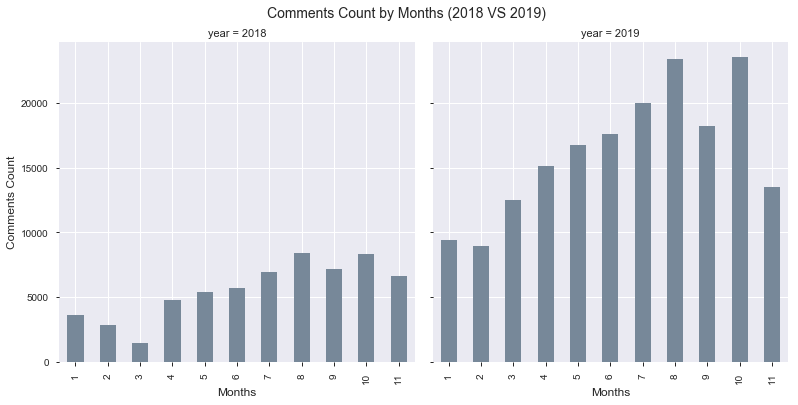

In [125]:
graph = sns.FacetGrid(reviews_df1_groupby, col="year", col_order=[2018, 2019], height=5.5, aspect=1)
def plot(*args,**kwargs):
    kwargs["data"].plot(kind="bar", x="month", y="count", ax=plt.gca(), color="lightslategray")
graph.map_dataframe(plot)
graph.set_xlabels('Months', fontsize=12, ha='center')
graph.set_ylabels('Comments Count', fontsize=12, ha='center')
graph.fig.suptitle('Comments Count by Months (2018 VS 2019)', fontsize=14, ha='center')
plt.subplots_adjust(top=0.89)
plt.show()

In [186]:
# Quick Observation here: August and October seems to be the peak season(?) 

def language_detection(texts):
    if re.search("[\u4e00-\u9FFF]", texts):
        return "zh"
    if re.search("[\uac00-\ud7a3]", texts) or re.search("[\u3040-\u30ff]", texts):
        return "ko/ja"
    if re.search("[\u0000-\u0080]", texts):
        return "eng"
    return "others"

reviews_df1['language'] = reviews_df1['comments'].apply(language_detection)
reviews_df1['language'].value_counts()

zh       227713
eng       19969
ko/ja       595
Name: language, dtype: int64

In [140]:
reviews_df1.drop(columns=['checked'])
reviews_df1[reviews_df1['language'] == "others"]

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,checked,language
4852,33277688,563718119,2019-11-13,222151154,悦,❤️,2019,11,-1,others
6268,37544533,562481261,2019-11-10,180627627,村村,️,2019,11,-1,others
7583,16803014,561591513,2019-11-09,184323119,曹,…,2019,11,-1,others
11537,39404957,558262432,2019-11-02,122488140,雁鹏,｡,2019,11,-1,others
11909,38965958,558296935,2019-11-02,244523868,博文,｡｡｡,2019,11,-1,others
13691,38704918,557350696,2019-10-31,46343534,昳,｡,2019,10,-1,others
17339,39474897,554695712,2019-10-26,303884647,瓜,☺️,2019,10,-1,others
19736,35717576,553304324,2019-10-23,303610030,佳淇小老弟,｡,2019,10,-1,others
20085,38908237,552941400,2019-10-22,303610030,佳淇小老弟,｡,2019,10,-1,others
20285,34615071,552941421,2019-10-22,260498899,Qi,️,2019,10,-1,others


In [187]:
reviews_df1 = reviews_df1[reviews_df1['language'] != "others"]
reviews_df1 = reviews_df1.reset_index(drop=True)
reviews_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248277 entries, 0 to 248276
Data columns (total 10 columns):
listing_id       248277 non-null int64
id               248277 non-null int64
date             248277 non-null object
reviewer_id      248277 non-null int64
reviewer_name    248277 non-null object
comments         248277 non-null object
year             248277 non-null int64
month            248277 non-null int64
checked          248277 non-null int64
language         248277 non-null object
dtypes: int64(6), object(4)
memory usage: 18.9+ MB


In [188]:
reviews_df1.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,checked,language
0,36018736,568874948,2019-11-25,34526793,Samy,this place is ideal if you want great value at...,2019,11,-1,eng
1,6767658,568861601,2019-11-25,211598454,京山,不错,2019,11,-1,zh
2,33185003,568863008,2019-11-25,309853029,Wei,we had a great time at lynn’s place. the locat...,2019,11,-1,eng
3,39025462,568773024,2019-11-24,216345408,朽,"房子蛮大,关上窗户就很安静｡设施齐全,地理位置也不错",2019,11,-1,zh
4,17546358,568805704,2019-11-24,293114959,广皓,"地点很方便,公共交通方便,旁边有一个比较大的超市,房屋隔音很好,也很舒适｡\n看到有其他房客...",2019,11,-1,zh
5,35640496,568790919,2019-11-24,297768582,沨夏夏夏,"房间很干净,交通很方便,房东小姐姐超级好!",2019,11,-1,zh
6,28725380,568809754,2019-11-24,215616456,晶涵,住过最好的民宿,2019,11,-1,zh
7,32504159,568787927,2019-11-24,308260179,ᴄʟᴀɪʀᴇ,"为了房东姐姐也得给满分评价,任何问题随时沟通,点儿多晚了都给解决｡地段没话说,应有尽有｡屋子...",2019,11,-1,zh
8,13456163,568808139,2019-11-24,172791122,志超,"房间很好,住着很舒服,房东是个美女,人很好",2019,11,-1,zh
9,35663711,568815219,2019-11-24,183207697,陈楠,"房东姐姐非常热情,随问随回复｡房子整体也比较干净整洁,离地铁站比较近,很方便｡这两天北京比较...",2019,11,-1,zh


In [189]:
reviews_df1_groupby_language = reviews_df1.groupby(['year', 'month', 'language']).comments.count()
reviews_df1_groupby_language = reviews_df1_groupby_language.to_frame('count')
reviews_df1_groupby_language.reset_index(inplace=True)
reviews_df1_groupby_language

,year,month,language,count
0,2018,1,eng,411
1,2018,1,ko/ja,11
2,2018,1,zh,3210
3,2018,2,eng,290
4,2018,2,ko/ja,8
5,2018,2,zh,2568
6,2018,3,eng,302
7,2018,3,ko/ja,8
8,2018,3,zh,1182
9,2018,4,eng,725


In [190]:
reviews_df1_groupby_language = pd.pivot_table(reviews_df1_groupby_language, index=['year', 'month'], columns=['language'],fill_value=0)
reviews_df1_groupby_language

count             
language     eng ko/ja     zh
year month                   
2018 1       411    11   3210
     2       290     8   2568
     3       302     8   1182
     4       725    13   4066
     5       756    22   4656
     6       754    21   4957
     7       843    29   6097
     8       824    15   7558
     9       838    24   6353
     10      824    24   7478
     11      814    31   5802
     12      785    17   6984
2019 1       750    25   8621
     2       529    18   8396
     3      1029    37  11437
     4      1385    45  13733
     5      1203    40  15506
     6      1283    40  16261
     7      1271    29  18685
     8      1181    46  22186
     9      1098    26  17113
     10     1266    42  22192
     11      808    24  12672

In [191]:
reviews_df1_groupby_language.to_csv('review_language.csv')

## Review Language Breakdown

Please bear in mind that this analysis is based on the following assumptions:

1. Customers who leave comment (sample) reflect the true population of Airbnb China.
2. Customers who leave English, Korean and Japanese comments are foreigners.
3. Customers who leave Chinese comments are most likely to be locals (travel within China). 
4. Of course, if we really wanted to verify assumptions 3, we could either scrap the user profile.

![alt text](review_01.jpg "Review_Language_Analysis")

In [196]:
# Suppose to have 1492 rows
reviews_sample = reviews_df1[reviews_df1['year'] == 2018]
reviews_sample = reviews_sample[reviews_sample['month'] == 3]
reviews_sample.shape

(1492, 10)

In [198]:
reviews_sample.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,checked,language
240287,16924533,248236062,2018-03-31,30428622,Shawn,great location! great place if you have a big ...,2018,3,-1,eng
240288,21938110,248211454,2018-03-31,41269289,Kayne,it’s a really nice place. convenient location....,2018,3,-1,eng
240289,20872463,248224972,2018-03-31,165909162,Xinming,the apartment is conveniently located. it is 5...,2018,3,-1,eng
240290,18079626,248186864,2018-03-31,12686627,Emilie,we stay here 2 months. excellent location and ...,2018,3,-1,eng
240291,18481741,248241636,2018-03-31,175564043,家名,干净整洁,2018,3,-1,zh


![alt text](china_tourist.png "China_Tourist_Analysis")